In [1]:
# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np

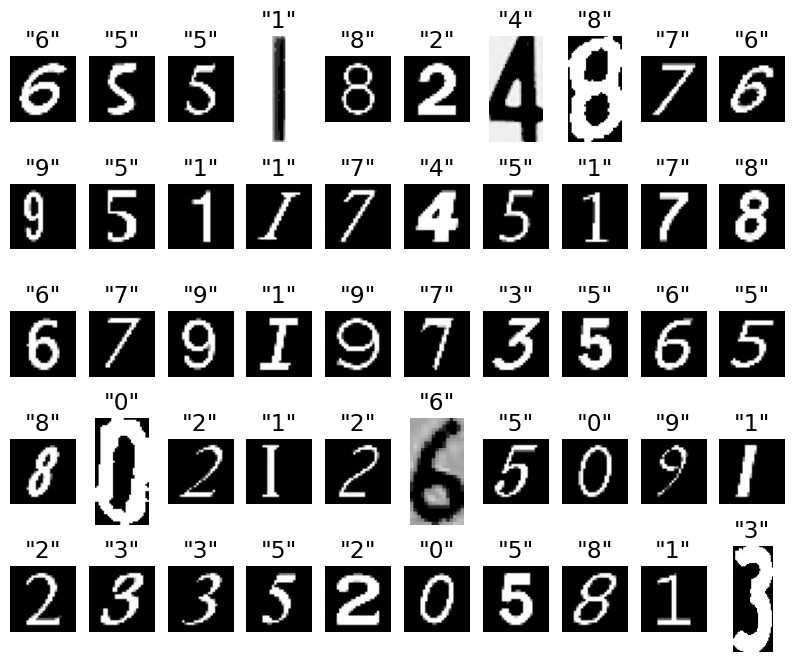

In [2]:
dataset_paths = glob.glob("../data/**/*.jpg")
dataset_paths = glob.glob("../data/**/*.png") + glob.glob("../data/**/*.jpg")
cols=10
rows=5
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

# plt.savefig("Visualize_dataset.jpg",dpi=300)


In [3]:
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes.npy', lb.classes_)

[INFO] Find 10372 images with 10 classes


Epoch 1/10
260/260 [==============================] - 35s 129ms/step - loss: 1.9669 - accuracy: 0.9026 - val_loss: 0.1389 - val_accuracy: 0.9682
Epoch 2/10
260/260 [==============================] - 37s 143ms/step - loss: 0.0641 - accuracy: 0.9831 - val_loss: 0.0955 - val_accuracy: 0.9773
Epoch 3/10
260/260 [==============================] - 37s 142ms/step - loss: 0.0446 - accuracy: 0.9893 - val_loss: 0.0885 - val_accuracy: 0.9798
Epoch 4/10
260/260 [==============================] - 37s 142ms/step - loss: 0.0204 - accuracy: 0.9959 - val_loss: 0.0489 - val_accuracy: 0.9889
Epoch 5/10
260/260 [==============================] - 37s 142ms/step - loss: 0.0340 - accuracy: 0.9907 - val_loss: 0.0651 - val_accuracy: 0.9865
Epoch 6/10
260/260 [==============================] - 36s 140ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 0.0580 - val_accuracy: 0.9899
Epoch 7/10
260/260 [==============================] - 36s 138ms/step - loss: 0.0193 - accuracy: 0.9958 - val_loss: 0.0456 - val_ac

c:\Users\thong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


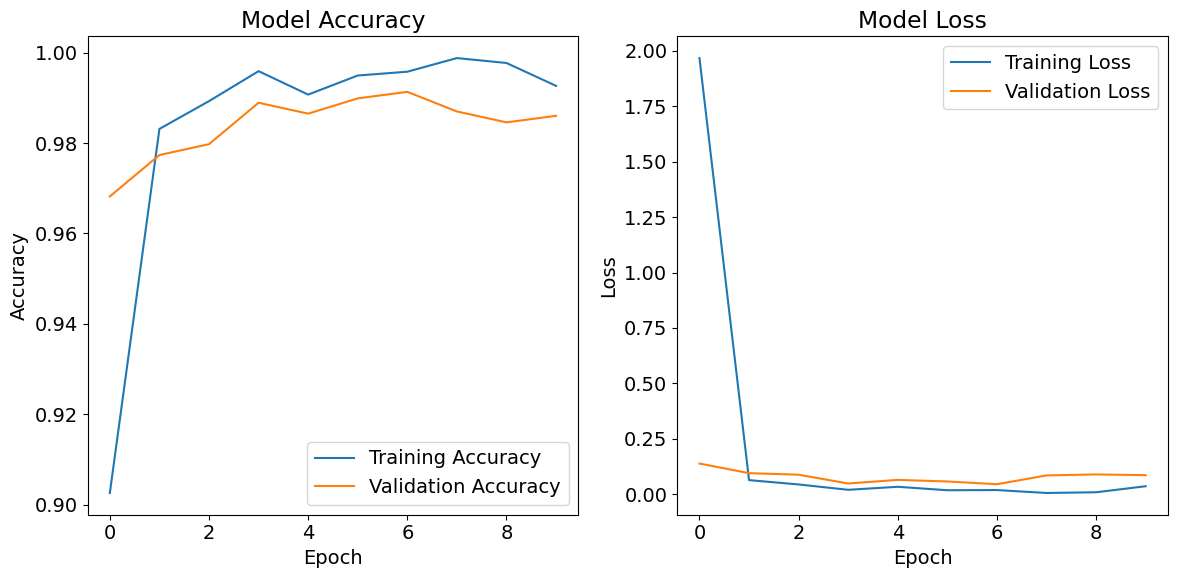

In [4]:
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
# Define the model architecture
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Define input shape and number of classes
input_shape = (80, 80, 3)  # Adjust channels if needed
num_classes = len(lb.classes_)

# Build the model
model = build_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Save the trained model
model.save('digit_recognition_model.h5')

# Visualize training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


65/65 [==============================] - 2s 37ms/step - loss: 0.0864 - accuracy: 0.9860
Test Loss: 0.08643645793199539
Test Accuracy: 0.9860240817070007


In [6]:
from keras.models import load_model
loaded_model = load_model('digit_recognition_model.h5')

# Load and preprocess the image
image_path = '../data/4/4_20.jpg' 
# Replace with the path to your image
image = load_img(image_path, target_size=(80, 80))  # Adjust the target_size if needed
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Make prediction
prediction = loaded_model.predict(image_array)

# Convert prediction to class label
predicted_class = np.argmax(prediction)

# Load the label classes saved earlier
label_classes = np.load('license_character_classes.npy')

# Get the corresponding class label
predicted_label = label_classes[predicted_class]

print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 186ms/step
Predicted Label: 4


In [7]:
# save model architectur as json file
model_json = loaded_model.to_json()
with open("Character_recognition.json", "w") as json_file:
  json_file.write(model_json)

In [8]:
loaded_model.save_weights('digit_recognition_model.h5')